# PDF to WordCloud via Email
> Receive a pdf via outlook mail and send back the wordcloud of that pdf in the reply

- toc: true
- badges: true
- comments: true
- categories: [nlp]
- image:

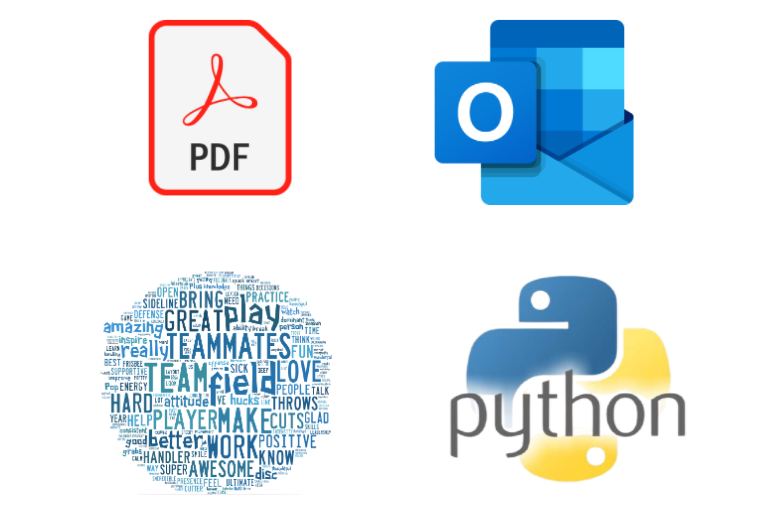

## Objective

Integrating PDF, Text, Wordcloud and Email functionalities in Python

## Process Flow

- Step 1 - PyPDF2 library to read PDF text in Python
- Step 2 - Import the supporting libraries
- Step 3 - Count No. of Pages for this pdf and extract text for each page using loop
- Step 4 - Build Text corpus by simply attaching text of next page to all the previous ones
- Step 5 - Creating word frequency dataframe by first splitting text into words and counting the frequency of each word
- Step 6.1 - Pre-process text i.e. removing stopwords (using nltk library), grouping common words.
- Step 6.2 - Used regex to extract alphabets only, lower all chracters, and sorting as per decreasing order of frequency.
- Step 7 - Creating Wordcloud using matplotlib and wordcloud libraries
- Step 8 - Importing required libraries like smtplib, MIME, win32 for sending the mail
- Step 9 - Create outlook mail object with supporting data like filepath attachment, recepient address, mail body etc.
- Step 10 - Sending the mail with required wordcloud image file attached and checking if mail is received or not!

In [ ]:
#!pip install PyPDF2

## Generating Word Frequency Dataframe from PDF File

In [ ]:
import os
import sys
import re
import time
import PyPDF2
import numpy as np
import pandas as pd

### Creating Word-Corpus

In [ ]:
def getPageCount(pdf_file):

    pdfFileObj = open(pdf_file, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    pages = pdfReader.numPages
    return pages

def removegarbage(str):
    # Replace one or more non-word (non-alphanumeric) chars with a space
    str = re.sub(r'\W+', ' ', str)
    str = str.lower()
    return str

def extractData(pdf_file, page):

    pdfFileObj = open(pdf_file, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    pageObj = pdfReader.getPage(page)
    data = pageObj.extractText()
    data = removegarbage(data)
    return data

def getWordCount(data):

    data=data.split()
    return len(data)

# get the word count in the pdf file
pdfFile = 'rj.pdf'
numPages = getPageCount(pdfFile)
corpus = ""
for i in range(numPages):
    corpus = corpus + " " + extractData(pdfFile, i)
time.sleep(1)

### Creating Word-Frequency Dataframe

In [ ]:
wordlist = corpus.split()
wordfreq = []
for w in wordlist:
    wordfreq.append(wordlist.count(w))
    
wordlist = pd.Series(wordlist)
wordfreq = pd.Series(wordfreq)
df = pd.DataFrame({'Words': wordlist})
df['Frequency'] = wordfreq
df = df.sort_values(by=['Frequency'], ascending=False)

### Text Pre-processing

In [ ]:
df1 = df.copy()
df1.loc[:,"Words"] = df1.Words.apply(lambda x : str.lower(x))

import re
df1.loc[:,"Words"] = df1.Words.apply(lambda x : " ".join(re.findall('[\w]+',x)))

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

df1.loc[:,"Words"] = df1.Words.apply(lambda x: remove_stopWords(x))

df1['Words'].replace('', np.nan, inplace=True)
df1.dropna(subset=['Words'], inplace=True)
df1 = df1.groupby('Words').sum().sort_values(by=['Frequency'], ascending=False)
df1 = df1.reset_index()

### Creating Word Cloud

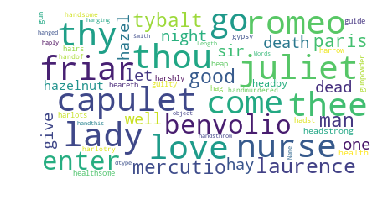

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df1['Words']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

### Importing Required libraries for sending Mail

In [ ]:
import os
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

### Send Email attaching the Wordcloud file

In [ ]:
import win32com.client as win32
outlook = win32.Dispatch('outlook.application')
mail = outlook.CreateItem(0)
mail.To = "abc@gmail.com"
mail.Subject = "Word cloud of the Novel PDF"
mail.Body = "Congratulation!, Your wordcloud has been generated. Please Find Attached toe required File!"

# To attach a file to the email (optional):
attachment  = "C:\\Users\\xyz\\word1.png"
mail.Attachments.Add(attachment)
#Sending the mail
mail.Send()